In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import warnings

# --- Konfigurasi Lingkungan ---
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

## KONFIGURASI PROYEK

In [ ]:
# Kita asumsikan kita berada di akhir November 2025
CURRENT_DATE = '2025-11-30'
FORECAST_START = '2025-12-01'
FORECAST_HORIZON = 31  # 31 Hari di Desember
INPUT_WINDOW = 60      # Menggunakan 60 hari ke belakang
VOL_WINDOW = 21        # Jendela volatilitas

print(f"--- MENJALANKAN ULTIMATE FORECASTER ---")
print(f"Target: Memprediksi Volatilitas Bitcoin {FORECAST_START} s.d. +{FORECAST_HORIZON} hari")

--- MENJALANKAN ULTIMATE FORECASTER ---
Target: Memprediksi Volatilitas Bitcoin 2025-12-01 s.d. +31 hari


## PERSIAPAN DATA & SAMPLE WEIGHTING

In [ ]:
print("\n[1/5] Mengambil & Memproses Data...")

# Ambil data
data = yf.download('BTC-USD', start='2018-01-01', end=CURRENT_DATE, interval='1d', progress=False)

# Hitung Log Return & Realized Volatility
data['log_return'] = np.log(data['Close'] / data['Close'].shift(1)) * 100
data['target_vol'] = data['log_return'].rolling(window=VOL_WINDOW).std() * np.sqrt(365)
data = data.dropna()

# --- IMPLEMENTASI SAMPLE WEIGHTING ---
# Kita buat bobot yang membesar secara eksponensial mendekati hari ini.
# Data lama punya bobot kecil, data baru punya bobot besar.
time_decay_factor = 0.0005  # Bisa disesuaikan
sample_weights = np.exp(np.linspace(0, time_decay_factor * len(data), len(data)))
# Normalisasi bobot agar rata-ratanya 1
sample_weights = sample_weights / np.mean(sample_weights)

# Simpan bobot ke dataframe sementara untuk alignment nanti
data['weight'] = sample_weights


[1/5] Mengambil & Memproses Data...


## PEMODELAN GARCH (Auto-Tuning Sederhana)

In [ ]:
print("\n[2/5] Mengoptimalkan Model GJR-GARCH...")

best_aic = np.inf
best_garch_model = None
best_garch_res = None
best_params = {}

# Grid Search Sederhana untuk GARCH
# Kita fokus pada p, q, dan jenis distribusi
dist_options = ['Normal', 't', 'skewt'] # Skewt bagus untuk crypto

for d in dist_options:
    try:
        # GJR-GARCH(1,1) adalah standar emas, kita tuning distribusinya saja
        # agar tidak terlalu lama. (p=1, o=1, q=1)
        temp_model = arch_model(data['log_return'], p=1, o=1, q=1, dist=d)
        temp_res = temp_model.fit(disp='off')

        if temp_res.aic < best_aic:
            best_aic = temp_res.aic
            best_garch_model = temp_model
            best_garch_res = temp_res
            best_params = {'dist': d}
    except:
        continue

print(f"   > GARCH Terbaik: GJR-GARCH(1,1) dengan distribusi '{best_params['dist']}' (AIC: {best_aic:.2f})")

# Forecasting GARCH (Recursive)
garch_forecast = best_garch_res.forecast(horizon=FORECAST_HORIZON, reindex=False)
garch_pred_variance = garch_forecast.variance.values.flatten()
garch_predictions = np.sqrt(garch_pred_variance) * np.sqrt(365)


[2/5] Mengoptimalkan Model GJR-GARCH...
   > GARCH Terbaik: GJR-GARCH(1,1) dengan distribusi 't' (AIC: 14110.50)


## PERSIAPAN DATA LSTM (VECTOR OUTPUT)

In [ ]:
print("\n[3/5] Menyiapkan Data LSTM (Direct Multi-step Strategy)...")

# Kita butuh format khusus:
# X: [Window 60 hari]
# y: [Vector 31 hari ke depan sekaligus]
# Weight: Bobot sampel pada titik prediksi

dataset = data[['target_vol']].values
weights_vals = data['weight'].values

scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)

X, y, w = [], [], []

# Loop pembuatan data
# Kita harus berhenti sebelum data habis agar cukup untuk mengambil 31 hari ke depan
for i in range(INPUT_WINDOW, len(dataset_scaled) - FORECAST_HORIZON + 1):
    X.append(dataset_scaled[i-INPUT_WINDOW:i, 0])      # Input: 60 hari ke belakang
    y.append(dataset_scaled[i:i+FORECAST_HORIZON, 0])  # Target: 31 hari ke depan (VECTOR)
    w.append(weights_vals[i+FORECAST_HORIZON-1])       # Weight: Kita ambil bobot di hari target

X, y, w = np.array(X), np.array(y), np.array(w)

# Reshape X agar sesuai input LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

print(f"   > Shape Input X: {X.shape} (Sampel, 60 Hari, 1 Fitur)")
print(f"   > Shape Target y: {y.shape} (Sampel, 31 Hari - Vector Output)")


[3/5] Menyiapkan Data LSTM (Direct Multi-step Strategy)...
   > Shape Input X: (2779, 60, 1) (Sampel, 60 Hari, 1 Fitur)
   > Shape Target y: (2779, 31) (Sampel, 31 Hari - Vector Output)


## LSTM HYPERPARAMETER TUNING (KERAS TUNER)

In [ ]:
print("\n[4/5] Menjalankan Hyperparameter Tuning Otomatis untuk LSTM...")

def build_model(hp):
    model = keras.Sequential()

    # Layer Input
    model.add(layers.Input(shape=(INPUT_WINDOW, 1)))

    # Tuning Jumlah Layer LSTM (1 atau 2)
    for i in range(hp.Int('num_lstm_layers', 1, 2)):
        model.add(layers.LSTM(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
            activation='tanh', # Tanh standar stabil untuk LSTM
            return_sequences=True if i == 0 and hp.Int('num_lstm_layers', 1, 2) > 1 else False
        ))
        # Tuning Dropout
        model.add(layers.Dropout(hp.Float('dropout', 0.1, 0.4, step=0.1)))

    # Output Layer: Langsung 31 Neuron (Direct Strategy)
    model.add(layers.Dense(FORECAST_HORIZON))

    # Tuning Learning Rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error'
    )
    return model

# Inisialisasi Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='btc_vol_forecast_v2',
    overwrite=True # Overwrite agar fresh setiap run
)

# Jalankan Search (Gunakan 20% data akhir sebagai validasi untuk tuning)
# Kita pass 'sample_weight' di sini!
split_at = int(len(X) * 0.8)
X_train_t, X_val_t = X[:split_at], X[split_at:]
y_train_t, y_val_t = y[:split_at], y[split_at:]
w_train_t, w_val_t = w[:split_at], w[split_at:]

tuner.search(
    X_train_t, y_train_t,
    sample_weight=w_train_t, # <--- PENERAPAN SAMPLE WEIGHTING
    epochs=15,
    validation_data=(X_val_t, y_val_t, w_val_t),
    verbose=1
)

# Ambil Model Terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"   > Parameter Terbaik Ditemukan: {best_hps.values}")

best_lstm = tuner.hypermodel.build(best_hps)

# Latih Ulang Model Terbaik pada SEMUA Data (Full Retrain)
print("   > Melatih ulang model terbaik pada data penuh...")
best_lstm.fit(X, y, sample_weight=w, epochs=30, batch_size=32, verbose=0)

# Prediksi LSTM untuk Desember 2025
# Inputnya adalah data 60 hari TERAKHIR yang tersedia
last_60_days = dataset_scaled[-INPUT_WINDOW:].reshape(1, INPUT_WINDOW, 1)
lstm_pred_scaled = best_lstm.predict(last_60_days)
lstm_predictions = scaler.inverse_transform(lstm_pred_scaled).flatten()

Trial 30 Complete [00h 01m 15s]
val_loss: 0.005815635900944471

Best val_loss So Far: 0.005217686761170626
Total elapsed time: 00h 20m 32s
   > Parameter Terbaik Ditemukan: {'num_lstm_layers': 1, 'units_0': 32, 'dropout': 0.30000000000000004, 'learning_rate': 0.01, 'units_1': 128, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
   > Melatih ulang model terbaik pada data penuh...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


## ENSEMBLE & HASIL AKHIR


[5/5] Menggabungkan Hasil (Ensemble)...

HASIL PREDIKSI VOLATILITAS (DESEMBER 2025)
   Tanggal  ENSEMBLE_FINAL
2025-12-01       49.098590
2025-12-02       49.294963
2025-12-03       49.418836
2025-12-04       49.346367
2025-12-05       49.687558
2025-12-06       49.940057
2025-12-07       50.417315
2025-12-08       50.815268
2025-12-09       51.400900
2025-12-10       51.384641
... (dan seterusnya sampai 31 Des)


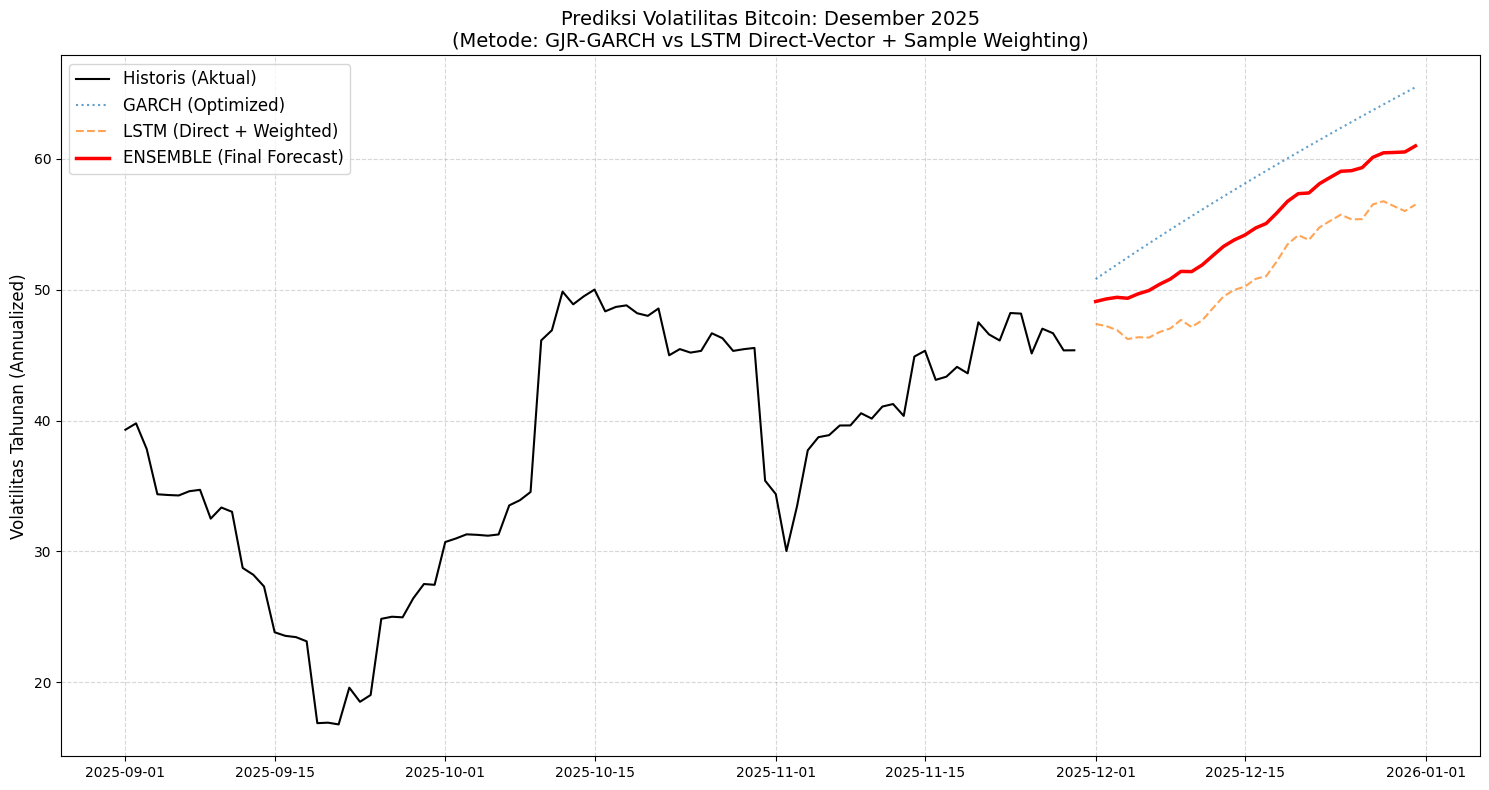

In [ ]:
print("\n[5/5] Menggabungkan Hasil (Ensemble)...")

# Strategi Ensemble: Weighted Average
# Kita beri bobot 50:50 karena kedua model sudah dioptimalkan
final_predictions = (0.5 * garch_predictions) + (0.5 * lstm_predictions)

# Buat DataFrame
dates = pd.date_range(start=FORECAST_START, periods=FORECAST_HORIZON)
df_result = pd.DataFrame({
    'Tanggal': dates,
    'GARCH_Optimized': garch_predictions,
    'LSTM_Direct_Weighted': lstm_predictions,
    'ENSEMBLE_FINAL': final_predictions
})

print("\n" + "="*50)
print("HASIL PREDIKSI VOLATILITAS (DESEMBER 2025)")
print("="*50)
print(df_result[['Tanggal', 'ENSEMBLE_FINAL']].head(10).to_string(index=False))
print("... (dan seterusnya sampai 31 Des)")

# --- VISUALISASI ---
plt.figure(figsize=(15, 8))

# Plot Data Historis (Zoom 3 bulan terakhir)
historical_subset = data.iloc[-90:]
plt.plot(historical_subset.index, historical_subset['target_vol'], label='Historis (Aktual)', color='black', linewidth=1.5)

# Plot Prediksi
plt.plot(df_result['Tanggal'], df_result['GARCH_Optimized'], label='GARCH (Optimized)', linestyle=':', alpha=0.7)
plt.plot(df_result['Tanggal'], df_result['LSTM_Direct_Weighted'], label='LSTM (Direct + Weighted)', linestyle='--', alpha=0.7)
plt.plot(df_result['Tanggal'], df_result['ENSEMBLE_FINAL'], label='ENSEMBLE (Final Forecast)', color='red', linewidth=2.5)

plt.title('Prediksi Volatilitas Bitcoin: Desember 2025\n(Metode: GJR-GARCH vs LSTM Direct-Vector + Sample Weighting)', fontsize=14)
plt.ylabel('Volatilitas Tahunan (Annualized)', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Simpan ke CSV untuk laporan

In [ ]:
df_result.to_csv('prediksi_volatilitas_dec_2025.csv', index=False)
print("\nHasil lengkap disimpan ke 'prediksi_volatilitas_dec_2025.csv'")


Hasil lengkap disimpan ke 'prediksi_volatilitas_dec_2025.csv'
